In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.dqn import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import trajectory
from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
env_name = 'CartPole-v0'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [4]:
env = suite_gym.load(env_name)

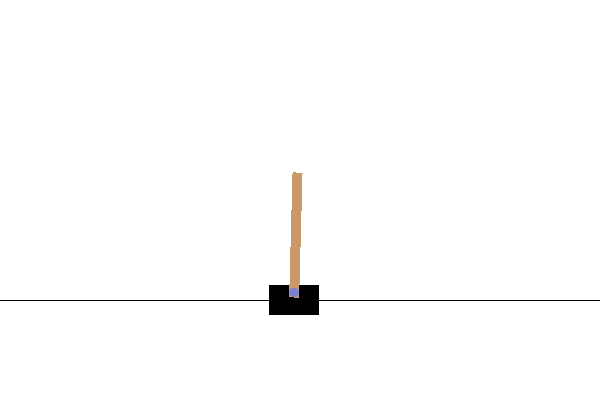

In [5]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

In [6]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


In [7]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = 1

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01419785, -0.02943233,  0.01313752, -0.02355465], dtype=float32))
Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.0136092 ,  0.16549878,  0.01266642, -0.31206375], dtype=float32))


In [8]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [9]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [10]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [11]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy


In [12]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [17]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

15.9

In [18]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [19]:
#@test {"skip": true}
def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)


for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

In [20]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [21]:
#@test {"skip": true}
#%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect one step using collect_policy and save to the replay buffer.
  collect_step(train_env, tf_agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience)

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 6.617764472961426


step = 400: loss = 12.133417129516602


step = 600: loss = 30.85879898071289


step = 800: loss = 11.422975540161133


step = 1000: loss = 17.160614013671875


step = 1000: Average Return = 19.600000381469727


step = 1200: loss = 37.90451431274414


step = 1400: loss = 9.424544334411621


step = 1600: loss = 9.386625289916992


step = 1800: loss = 20.75423812866211


step = 2000: loss = 20.480701446533203


step = 2000: Average Return = 21.799999237060547


step = 2200: loss = 21.044681549072266


step = 2400: loss = 19.342044830322266


step = 2600: loss = 43.05093002319336


step = 2800: loss = 10.749832153320312


step = 3000: loss = 31.31725311279297


step = 3000: Average Return = 71.5999984741211


step = 3200: loss = 70.2099838256836


step = 3400: loss = 36.99456024169922


step = 3600: loss = 81.84960174560547


step = 3800: loss = 11.886451721191406


step = 4000: loss = 61.64696502685547


step = 4000: Average Return = 77.5


step = 4200: loss = 136.42454528808594


step = 4400: loss = 29.255739212036133


step = 4600: loss = 54.0104866027832


step = 4800: loss = 85.774658203125


step = 5000: loss = 26.761260986328125


step = 5000: Average Return = 77.9000015258789


step = 5200: loss = 107.18711853027344


step = 5400: loss = 6.381505966186523


step = 5600: loss = 169.08416748046875


step = 5800: loss = 74.54991149902344


step = 6000: loss = 50.94526672363281


step = 6000: Average Return = 134.6999969482422


step = 6200: loss = 51.49197769165039


step = 6400: loss = 68.89533233642578


step = 6600: loss = 27.226318359375


step = 6800: loss = 223.42626953125


step = 7000: loss = 37.327491760253906


step = 7000: Average Return = 118.69999694824219


step = 7200: loss = 32.78984832763672


step = 7400: loss = 15.472600936889648


step = 7600: loss = 203.68399047851562


step = 7800: loss = 201.47879028320312


step = 8000: loss = 77.28562927246094


step = 8000: Average Return = 178.39999389648438


step = 8200: loss = 159.42361450195312


step = 8400: loss = 119.39494323730469


step = 8600: loss = 99.69429779052734


step = 8800: loss = 407.2831115722656


step = 9000: loss = 338.8082275390625


step = 9000: Average Return = 198.60000610351562


step = 9200: loss = 194.360107421875


step = 9400: loss = 305.8352355957031


step = 9600: loss = 59.958229064941406


step = 9800: loss = 342.77154541015625


step = 10000: loss = 596.0716552734375


step = 10000: Average Return = 194.10000610351562


step = 10200: loss = 16.007827758789062


step = 10400: loss = 154.28445434570312


step = 10600: loss = 15.910346984863281


step = 10800: loss = 577.1912231445312


step = 11000: loss = 197.8243408203125


step = 11000: Average Return = 200.0


step = 11200: loss = 20.139629364013672


step = 11400: loss = 25.645511627197266


step = 11600: loss = 191.56675720214844


step = 11800: loss = 21.217174530029297


step = 12000: loss = 309.4866638183594


step = 12000: Average Return = 200.0


step = 12200: loss = 248.66571044921875


step = 12400: loss = 581.8751220703125


step = 12600: loss = 783.230712890625


step = 12800: loss = 259.24554443359375


step = 13000: loss = 668.2537841796875


step = 13000: Average Return = 200.0


step = 13200: loss = 450.5958557128906


step = 13400: loss = 477.6687927246094


step = 13600: loss = 507.8236389160156


step = 13800: loss = 1413.079833984375


step = 14000: loss = 267.378662109375


step = 14000: Average Return = 199.0


step = 14200: loss = 39.327117919921875


step = 14400: loss = 1679.4249267578125


step = 14600: loss = 37.44207000732422


step = 14800: loss = 70.47071075439453


step = 15000: loss = 29.146305084228516


step = 15000: Average Return = 200.0


step = 15200: loss = 23.64971923828125


step = 15400: loss = 37.06902313232422


step = 15600: loss = 61.15703582763672


step = 15800: loss = 52.32779312133789


step = 16000: loss = 1132.172119140625


step = 16000: Average Return = 200.0


step = 16200: loss = 75.35420227050781


step = 16400: loss = 61.783302307128906


step = 16600: loss = 1177.4437255859375


step = 16800: loss = 60.699729919433594


step = 17000: loss = 79.699951171875


step = 17000: Average Return = 200.0


step = 17200: loss = 1062.2568359375


step = 17400: loss = 953.3456420898438


step = 17600: loss = 41.14030456542969


step = 17800: loss = 54.06980514526367


step = 18000: loss = 83.62663269042969


step = 18000: Average Return = 200.0


step = 18200: loss = 43.177433013916016


step = 18400: loss = 56.276458740234375


step = 18600: loss = 72.49714660644531


step = 18800: loss = 973.2488403320312


step = 19000: loss = 78.27286529541016


step = 19000: Average Return = 200.0


step = 19200: loss = 54.23822021484375


step = 19400: loss = 458.31036376953125


step = 19600: loss = 43.07231140136719


step = 19800: loss = 518.489990234375


step = 20000: loss = 75.92179107666016


step = 20000: Average Return = 200.0


(2.705000400543213, 250)

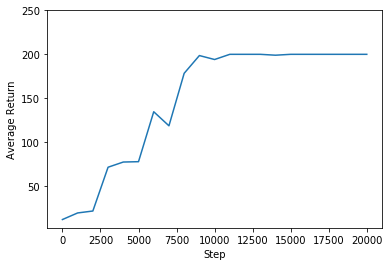

In [22]:

#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [23]:

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [24]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

W0312 19:00:29.283687 140098531624704 _io.py:352] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAn+9tZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyByMjkzNSA1NDVkZTJmIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxOCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEyIGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjUuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAAetliIQAI//+9KD4FM+hS8rMVr3YiJg5QODsnDOHYAApX2AAAAMALDaxmsgzoPyngAAAhwAcIQUMoPMRMVYqBKnZ5jDHkAKDkyXalJhTLHK8ze+duklio2tuOfX3PqpsDv3KBvfnRiCI+OvuXGrNnA0rUX+uap+68f6BR5jKrp9py3+rhQRtNhxpHSSoD/PP+5753VqytBqJDPt3JmTUIIn100/rd8p+vXIP8ycTp5qzvt1naKyDX4sZwXGE+nyKh06Drpf+OgTgo2GziEpxfof+u9Dx8gSJtzGmlmKV2MNlQjuKXuDYJp8HTJhLSyXLZt3w5AC64AAXLeTJp5sOaiOSYRMzCjPYdyZCTp720B3gRJ/z/Puj9OSlrGcyTAQzApu/6CM8Rx+7Q1Pto4djM/nTKzhDVxDUsUNnYNoMeYwz/X6FKEaQM224XKPc9TSUdnRjfGKymwwTb+m9ZtuvlwxuomEzQcJsSj/n632KRh1BbVFeSLydDHjW8QTd06SxNKoRzerF89IRZE2xwCf91GzG0LYo1LjXpCE/e3awP49xE50YHxNh6YrIdk0EpAAAIHjFw4AeTs1cSfUM5cIuyjiSpFf2Rmj86uFW+sTTnOjkkTLU/YUIShbh7dUB8rSZ2Z5GAAADAAADAAAsYQAAAKRBmiRsQj/6WAAAHnnzSgMEyTx+Z/DqFVWc1cZLjWDv5eTp5VecSDlzjIgdFWSCcgIBtMy4/04mqDGnBPFGfnIdCNT+v8m/MzW1jx972ppZhbbOkfbJiBR8u4BjAo67/yILATQiv3NVMXBsjZX5XEZsYZbJBDA2XZQ2qsjqz53tP9xehBVMufXR7MBTzZ+53n++5a2NkJaEfEU+hwG/bYvnP/qc7gAAAFJBnkJ4hH8AACxeNKj4UDS6YBOa1YLHro7IOPxsQL5jMW8/b5r/7o++Y+7sgqPH5s/jV7rdei2EmJF47+9OBO8VTLN3w+DUhe8TadDMLIk6VhbdAAAAKgGeYXRH/wAAFY3IHvnSX5J+gLX3kmUepMw2DklZWTJ6AV+QHq9G2it2zAAAACkBnmNqR/8AADc6tCYwpDznxjQoA5sIaCH/P9z0U3uCLtGQAQ3CvmEMoQAAAGRBmmhJqEFomUwIR//6WAAAHn98ARB5u3J2D+k84rABno717/zYrbHDDU950AOBk5+LszKtnwmO2pSwsVViqVrlx04M7Oye9bqZvvjVKUTDU9B5BJXGuRS4tAFHpWI9T/0LVUP5AAAAN0GehkURLCP/AAAsWO5b6IC1AfA8+ud7z4F0zuW35+hxSiXc1KHvUB+LXFD/cee1ABWtPtzjCsEAAAApAZ6ldEf/AAAVAMH/Fs5Jx9wthVGZ9ENk2fv+j2xTZqIq/88iQG9p7bkAAAAjAZ6nakf/AAAVDOmQw5hf71BwU2/P/m1zGDwDgyUb5QMhQVgAAABGQZqrSahBbJlMCEf/+lgAAB51zX99POk/s1vOJlvE+ZmIbSB53xwaSA45PkL8QBKx377Tn5WBdZjeHYIysqYFOELpMLnWgAAAADtBnslFFSx/AAA3Uisg+LYHvUKto7q3v34JArLAsazliqqBUilRUZh2+aFG1jbQ9QXzyTL2eRPucLTegQAAAB0BnupqR/8AADcXyib1EfWUt2zsLite6OAGPksOSAAAAGxBmuxJqEFsmUwIR//6WAAAC74ZZA9EB3h1+p/vM3ac3wWzJ2i1EA/0wjqitXh6jpWEuSI2Xl4ELiB0aHi5NmfhezdNlAp3JZ5ehQVZhT7MtktebMCE1VJNWnLsgWw+l7ANaZR6883m0nuGdUAAAACQQZsQSeEKUmUwIR/6WAAAHnUbJQBRfeWQ+mHsUPQPzY/jPehEE9auqJs4yCLcxj5qDCW26xR/tYOZJmAs5S2h01jdzwI1fa8v73nI31SkclAgXYMM35FzPI1A03/orY4MLDwF0jwZLLl777Xs43fDOaDXc+kAM3FhqV2F+vS6EbECNU+57KN4fu2Llo9M4Kd9AAAAOEGfLkU0TCP/AAAsQFqN5jTfjsfxFGArLL79rnFLZe+zpPYEOAX5V5Ua0LCiQiFHmuUji8e4LeYLAAAAGwGfTXRH/wAANy9FY9m50dCv7dfk250opGxDuwAAADUBn09qR/8AADdSKyD8DVtAbXgGBUCvS9q0LQN0miyG1msSABCABmBSkN2aOrH+8MH5S07WwAAAAGhBm1RJqEFomUwI//pYAAAei8xykJZ2JMgRgBpDSAo5O1/xlCw4Ly2v8NJ5wACKzGOMjw+fiBkvpSrsb1t7Ptyr0rgwA/GYTOQPkcWuXuZRfwJ7emBh+yd64jchGyOWktnUP3L1VIaL0AAAAEZBn3JFESwj/wAALFaT50MmlPSQcBHRJ4e1MIhCwFoLi3euFKfkbu0S8OhVxxBa4yJomUGLGIApRLYHeCCxLusGj3dpCOWBAAAAKAGfkXRH/wAAN1iyMsCyFX1otokgbcS2EDYRAX1D2XxEPZpcENRa3KgAAAAtAZ+Takf/AAAVANff5gvvY03qPQ4AH8xp+20MGWuiDXzvMY4HZ7JWreDTAzsfAAAAbUGblkmoQWyZTBRMf/pYAAAeXaaLqx/Rt2J98xCaw71kcOYTyopbdOAK1wr779pXV3sE1JvgPLDQiCpnc38IOcQyYhrOuQ6Sg9R4govgEbUr19tkCnhB1MKaWgo8yyo6CT+drDRLJc2tepZgaxEAAAAvAZ+1akf/AAA3OfktozuZrU+DAIQV+JpIa1E6rTFknFg5rjav5W5MJG7C2wxq4sAAAABuQZu4SeEKUmUwUsI/+lgAAB51y0v4tIIe6EhG7VGGGdgNaNCRvOiL+4h4NDAh1TXfNo/6YniBf1xU3kGKav/vS8vQjElFJ3tBr3Il6cTAFZmw0WArIDNq6S2mdqz